# Project 01. Funnel Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Read Data](#readdata)
  2. [Funnel Conversion Rate](#funnelconversionrate)
  3. [Other Insights](#otherinsights)

<a id='read_data'></a>
## Read Data

In [2]:
# Since 'user_id' is the key of all the tables, change all the index in tables to be 'user_id'.
data = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/user_table.csv', index_col='user_id')
data.head()

,date,device,sex
user_id,,,
450007,2015-02-28,Desktop,Female
756838,2015-01-13,Desktop,Male
568983,2015-04-09,Desktop,Male
190794,2015-02-18,Desktop,Female
537909,2015-01-15,Desktop,Male


In [3]:
home = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/home_page_table.csv',index_col='user_id')
search = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/search_page_table.csv',index_col='user_id')
pay = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/payment_page_table.csv',index_col='user_id')
confirmation = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/payment_confirmation_table.csv',index_col='user_id')

In [4]:
# add one column 'page' to the data to show the status 
data.loc[home.index,'page'] = home['page']
data.loc[search.index,'page'] = search['page']
data.loc[pay.index,'page'] = pay['page']
data.loc[confirmation.index, 'page'] = confirmation['page']
data.head()

,date,device,sex,page
user_id,,,,
450007,2015-02-28,Desktop,Female,home_page
756838,2015-01-13,Desktop,Male,home_page
568983,2015-04-09,Desktop,Male,search_page
190794,2015-02-18,Desktop,Female,search_page
537909,2015-01-15,Desktop,Male,home_page


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 450007 to 438929
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    90400 non-null  object
 1   device  90400 non-null  object
 2   sex     90400 non-null  object
 3   page    90400 non-null  object
dtypes: object(4)
memory usage: 5.9+ MB


In [6]:
#change the date from object to datetime
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 450007 to 438929
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    90400 non-null  datetime64[ns]
 1   device  90400 non-null  object        
 2   sex     90400 non-null  object        
 3   page    90400 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 5.9+ MB


<a id='funnelconversionrate'></a>
## Funnel Conversion Rate

In [7]:
#define a new dataframe to show the stay, convert_rate etc.
# ??? not right
def convert_rate(data):
    summary = pd.DataFrame()
    number = data['page'].value_counts()
    summary['stay'] = number
    summary['total'] = data.shape[0],search.shape[0],pay.shape[0],confirmation.shape[0]
    summary['convertion_rate'] = (summary['stay'])/summary['total']
    return summary

In [8]:
data.groupby('device').apply(convert_rate)

stay  total  convertion_rate
device                                                          
Desktop home_page                  30100  60200         0.500000
        search_page                27090  45200         0.599336
        payment_page                2860   6030         0.474295
        payment_confirmation_page    150    452         0.331858
Mobile  home_page                  15100  30200         0.500000
        search_page                12080  45200         0.267257
        payment_page                2718   6030         0.450746
        payment_confirmation_page    302    452         0.668142

<a id='otherinsights'></a>
## Other Insights

In [9]:
# Transfer column 'weekday' to be day_name and 'page' to be int (0 or 1)
data_=data.copy()
data_['date']=data['date'].dt.day_name()
data_['page']= (data['page']=='payment_confirmation_page').astype(int)

data_.head()

,date,device,sex,page
user_id,,,,
450007,Saturday,Desktop,Female,0
756838,Tuesday,Desktop,Male,0
568983,Thursday,Desktop,Male,0
190794,Wednesday,Desktop,Female,0
537909,Thursday,Desktop,Male,0


In [12]:
# check the influence of date(weekday) by calculating averaged conversion rate of everyday
weekday = data_.groupby('date')['page'].agg(['count','mean']).sort_values(by='mean')
weekday.loc['Average'] = weekday.mean()
weekday['compared with the average'] = (weekday['mean']-weekday.loc['Average','mean'])/weekday.loc['Average','mean']
weekday

,count,mean,compared with the average
date,,,
Wednesday,12831.000000,0.004209,-0.158227
Friday,12750.000000,0.004235,-0.152880
Sunday,12922.000000,0.004798,-0.040326
Thursday,13444.000000,0.004909,-0.018078
Tuesday,12697.000000,0.005434,0.086950
Saturday,12801.000000,0.005468,0.093744
Monday,12955.000000,0.005944,0.188817
Average,12914.285714,0.005000,0.000000


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

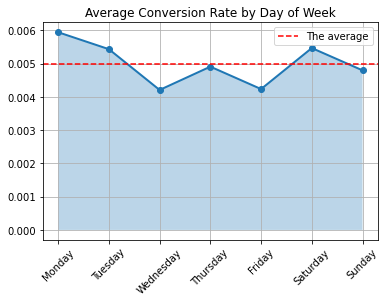

In [13]:
# visualization of influence of weekday
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','Average']
weekday1 = weekday.reindex(cats)
x = weekday1.drop('Average').index
y = weekday1.drop('Average')['mean']

fig,ax = plt.subplots()
plt.grid(True)
ax.plot(x,y,lw=2,marker='o')
ax.fill_between(x,0,y,alpha=0.3)

plt.axhline(y = weekday1.loc['Average','mean'],color = 'r', linestyle = '--',label='The average')
plt.legend()
plt.title('Average Conversion Rate by Day of Week')
plt.xticks(rotation=45)


In [14]:
# check the device influence
device = data_.groupby('device')['page'].agg(['count','mean']).sort_values(by='mean')
device.loc['Difference']=(device.loc['Mobile']-device.loc['Desktop'])/device.loc['Desktop']
device

,count,mean
device,,
Desktop,60200.000000,0.002492
Mobile,30200.000000,0.010000
Difference,-0.498339,3.013333


In [15]:
# check the sex influence
sex = data_.groupby('sex')['page'].agg(['count','mean']).sort_values(by='mean')
sex.loc['Difference']=(sex.loc['Male']-sex.loc['Female'])/sex.loc['Male']
sex

,count,mean
sex,,
Male,45325.000000,0.004655
Female,45075.000000,0.005347
Difference,0.005516,-0.148515


Summary:
1. The first day of the typical workweek produced about 18% higher conversion rate than the average.And Friday's conversion rate show 15% lower than the average. This make sense, since people usually shop more at the begining of the weak and on Friday they prefer social activities, entertainment etc.
2. The count of using mobile is  50% less thanof that of desktop users, but the conversion rate is more than 3 times than that of desktop. 
3. The male and female has almost the same counts, but the conversion rate of Female is almost 15% higher than that of Male.